In [88]:
import tensorflow as tf
initializer = tf.compat.v1.global_variables_initializer()

In [1]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

2024-04-21 12:50:55.555438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 12:50:55.555529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 12:50:55.661735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import numpy as np
import keras
from keras import layers
import keras
from keras.applications import ResNet50V2
from keras.applications.resnet50 import preprocess_input, decode_predictions

## Preprocessing the data so that ResNet can accept medical images

In [3]:
# def load_preprocessed_dicom_files(directory):
#     images = []
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file.endswith('.dcm'):
#                 file_path = os.path.join(root, file)
#                 image = load_and_preprocess_dicom(file_path)
#                 images.append(image)
#     return np.array(images)

In [4]:
# def load_and_preprocess_dicom(file_path, img_size=(224, 224)):
#     # Load the DICOM file
#     dicom = pydicom.dcmread(file_path)

#     # Apply VOI LUT if available to get the correct values
#     image = apply_voi_lut(dicom.pixel_array, dicom)

#     # Convert to float to avoid overflow or underflow losses
#     image = image.astype(float)

#     # Rescale the image
#     image -= image.min()
#     image /= image.max()
#     image *= 255.0  # Scale images to the range [0, 255]

#     # Convert to uint8
#     image = np.uint8(image)

#     # Resize the image
#     image = cv2.resize(image, img_size)

#     # If the DICOM image is color, convert to RGB; if grayscale, reshape for consistency
#     if len(image.shape) == 2:
#         image = np.stack((image,) * 3, axis=-1)  # Convert grayscale to RGB by repeating the channel
#     elif len(image.shape) == 3 and image.shape[2] == 3:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

#     return image

In [5]:
def load_and_preprocess_dicom(file_path, img_size=(224, 224)):
    dicom = pydicom.dcmread(file_path)
    image = apply_voi_lut(dicom.pixel_array, dicom)
    image = image.astype(float)
    image -= image.min()
    image /= image.max()
    image *= 255.0
    image = np.uint8(image)
    image = cv2.resize(image, img_size)
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0  # Final normalization
    return image

## X TRAINING DATA IS HERE

In [6]:
#loading the  input data from path
X_train_path = '/kaggle/input/images-train'
X_test_path = '/kaggle/input/images-test'
X_valid_path = '/kaggle/input/images-valid'

# train_X = load_preprocessed_dicom_files(X_train_path)
# valid_X = load_preprocessed_dicom_files(X_valid_path)
# test_X  = load_preprocessed_dicom_files(X_test_path)

In [7]:
labels_csv = '/kaggle/input/train-csv/train.csv'
labels_df = pd.read_csv(labels_csv)
labels_df = labels_df.iloc[:, [2, 3]]

## Splitting data

In [8]:
# Folder path relative to the current working directory in JupyterLab
folder_path = '/kaggle/input/data-path'  # Adjust as necessary

# Verify the correct folder path
if os.path.exists(folder_path):
    print("Directory exists:", folder_path)
else:
    print("Directory does not exist:", folder_path)

# List to hold filenames without the '.dcim' extension
file_names_without_extension = []

# Loop through each file in the directory
for filename in os.listdir(folder_path):
    # Print each filename for debugging
    #print("Found file:", filename)

    # Check for '.dcim' extension considering case sensitivity
    if filename.lower().endswith('.dcm'):
        # Remove the '.dcim' extension and add to the list
        clean_name = filename[:-4]  # This removes the last 5 characters, i.e., '.dcim'
        file_names_without_extension.append(clean_name)

# Print the list of cleaned names
#print("Files without .dcim extension:", file_names_without_extension)


Directory exists: /kaggle/input/data-path


In [9]:
#cleaning the csv so that it only has the relevant labels
valid_uids = file_names_without_extension

# Filter the DataFrame
filtered_df = labels_df[labels_df['SOPInstanceUID'].isin(valid_uids)]

# # Optional: Save the filtered DataFrame to a new CSV file
# filtered_df.to_csv('filtered_csv_file.csv', index=False)

In [10]:
labels=filtered_df

In [11]:
# Folder path relative to the current working directory in JupyterLab
folder_path = '/kaggle/input/images-train'  # Adjust as necessary

# Verify the correct folder path
if os.path.exists(folder_path):
    print("Directory exists:", folder_path)
else:
    print("Directory does not exist:", folder_path)

# List to hold filenames without the '.dcim' extension
train_ids = []

# Loop through each file in the directory
for filename in os.listdir(folder_path):
    # Print each filename for debugging
    #print("Found file:", filename)

    # Check for '.dcim' extension considering case sensitivity
    if filename.lower().endswith('.dcm'):
        # Remove the '.dcim' extension and add to the list
        clean_name = filename[:-4]  # This removes the last 5 characters, i.e., '.dcim'
        train_ids.append(clean_name)

# Print the list of cleaned names
#print("Files without .dcim extension:", file_names_without_extension)


Directory exists: /kaggle/input/images-train


In [12]:
train_labels = labels_df[labels_df['SOPInstanceUID'].isin(train_ids)]

In [13]:
# Folder path relative to the current working directory in JupyterLab
folder_path = '/kaggle/input/images-test'  # Adjust as necessary

# Verify the correct folder path
if os.path.exists(folder_path):
    print("Directory exists:", folder_path)
else:
    print("Directory does not exist:", folder_path)

# List to hold filenames without the '.dcim' extension
test_ids = []

# Loop through each file in the directory
for filename in os.listdir(folder_path):
    # Print each filename for debugging
    #print("Found file:", filename)

    # Check for '.dcim' extension considering case sensitivity
    if filename.lower().endswith('.dcm'):
        # Remove the '.dcim' extension and add to the list
        clean_name = filename[:-4]  # This removes the last 5 characters, i.e., '.dcim'
        test_ids.append(clean_name)

# Print the list of cleaned names
#print("Files without .dcim extension:", file_names_without_extension)


Directory exists: /kaggle/input/images-test


In [14]:
test_labels = labels_df[labels_df['SOPInstanceUID'].isin(test_ids)]

In [15]:
# Folder path relative to the current working directory in JupyterLab
folder_path = '/kaggle/input/images-valid'  # Adjust as necessary

# Verify the correct folder path
if os.path.exists(folder_path):
    print("Directory exists:", folder_path)
else:
    print("Directory does not exist:", folder_path)

# List to hold filenames without the '.dcim' extension
valid_ids = []

# Loop through each file in the directory
for filename in os.listdir(folder_path):
    # Print each filename for debugging
    #print("Found file:", filename)

    # Check for '.dcim' extension considering case sensitivity
    if filename.lower().endswith('.dcm'):
        # Remove the '.dcim' extension and add to the list
        clean_name = filename[:-4]  # This removes the last 5 characters, i.e., '.dcim'
        valid_ids.append(clean_name)

# Print the list of cleaned names
#print("Files without .dcim extension:", file_names_without_extension)

Directory exists: /kaggle/input/images-valid


In [16]:
valid_labels = labels_df[labels_df['SOPInstanceUID'].isin(valid_ids)]

In [17]:
def load_preprocessed_dicom_files(directory):
    images = []
    identifiers = []
    for root, dirs, files in os.walk(directory):
        for file in sorted(files):  # Ensure files are processed in a deterministic order
            if file.endswith('.dcm'):
                file_path = os.path.join(root, file)
                image = load_and_preprocess_dicom(file_path)
                images.append(image)
                identifiers.append(file)  # Save the file name or another unique identifier
    return np.array(images), identifiers

In [18]:
train_X, train_ids = load_preprocessed_dicom_files(X_train_path)
valid_X, valid_ids = load_preprocessed_dicom_files(X_valid_path)
test_X, test_ids = load_preprocessed_dicom_files(X_test_path)

In [38]:
print("Train Set Shape:", train_X.shape)
print("Validation Set Shape:", valid_X.shape)
print("Test Set Shape:", test_X.shape)

Train Set Shape: (108, 224, 224, 3)
Validation Set Shape: (12, 224, 224, 3)
Test Set Shape: (12, 224, 224, 3)


In [39]:
def align_images_and_labels(images, ids, labels_df):
    # Map each image ID to its index in the images array
    id_to_index = {image_id: idx for idx, image_id in enumerate(ids)}
    
    # Assuming 'SOPInstanceUID' is the column for image IDs
    # and 'pe_present_on_image' is the column for the labels
    sorted_labels_df = labels_df.set_index('SOPInstanceUID').reindex(ids).reset_index()
    
    # Sort the images array according to the sorted label dataframe
    sorted_images = np.array([images[id_to_index[image_id]] for image_id in sorted_labels_df['SOPInstanceUID']])
    
    # Extract labels
    sorted_labels = sorted_labels_df['pe_present_on_image'].values
    
    return sorted_images, sorted_labels


In [40]:
train_X, train_y = align_images_and_labels(train_X, train_ids, train_labels)
valid_X, valid_y = align_images_and_labels(valid_X, valid_ids, valid_labels)
test_X, test_y = align_images_and_labels(test_X, test_ids, test_labels)

In [89]:
# Assuming train_y and valid_y are pandas Series or numpy arrays wrapped in a DataFrame
train_df = pd.DataFrame({"features": train_X.tolist(), "label": train_y})
valid_df = pd.DataFrame({"features": valid_X.tolist(), "label": valid_y})

# Drop NaNs in labels
train_df = train_df.dropna(subset=["label"])
valid_df = valid_df.dropna(subset=["label"])

# Extract features and labels again
train_X = np.array(train_df["features"].tolist())
train_y = train_df["label"].values
valid_X = np.array(valid_df["features"].tolist())
valid_y = valid_df["label"].values


 ### Here, we instantiate a base model with pre-trained weights.

In [90]:
base_model = keras.applications.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

### Then, we freeze the base model.


In [91]:
base_model.trainable = False

### Create a new model on top of the pretrained model

In [92]:
# inputs = keras.Input(shape=(224, 224, 3))
# x = base_model(inputs, training=False)
# # Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

model = keras.Sequential([
    base_model,
    layers.Flatten(),
#     layers.Dense(6, activation='swish'),
#     layers.Dense(6, activation='swish'),
#     layers.Dense(6, activation='swish'),
    layers.Dense(6, activation = 'swish'),
    layers.Dense(1, activation='sigmoid'),
])

### Training the new model on blood clot data

In [93]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.00001, # minimium amount of change to count as an improvement
    patience= 30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [98]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

model.compile(optimizer='adam',
              loss=BinaryCrossentropy(from_logits=False),  # Ensure this is an instance
              metrics=['binary_accuracy'])

history = model.fit(train_X, train_y,
                    validation_data=(valid_X, valid_y),
                    batch_size=64,
                    epochs=300,
                    callbacks=[early_stopping],  # Assuming this is correctly defined elsewhere
                    verbose=1)  # Consider setting verbose to 1 to see the progress

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 71s 23s/step - binary_accuracy: 1.0000 - loss: 7.4507e-07 - val_binary_accuracy: 1.0000 - val_loss: 5.1516e-16
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - binary_accuracy: 1.0000 - loss: 5.4978e-09 - val_binary_accuracy: 1.0000 - val_loss: 2.3673e-17
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - binary_accuracy: 1.0000 - loss: 6.3314e-10 - val_binary_accuracy: 1.0000 - val_loss: 5.0864e-19
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - binary_accuracy: 1.0000 - loss: 3.7037e-10 - val_binary_accuracy: 1.0000 - val_loss: 1.0833e-19
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - binary_accuracy: 1.0000 - loss: 1.0058e-10 - val_binary_accuracy: 1.0000 - val_loss: 1.5456e-19
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - binary_accuracy: 1.0000 - loss: 1.1098e-10 - val_binary_accuracy: 1.0000 - val_loss: 1.1486e-19
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - binary_accuracy: 1.0000 - loss: 1.7414e-10 - val_binar

In [97]:
# history = model.fit(
#     train_X, train_y,
#     validation_data=(valid_X, valid_y),
#     batch_size=64,
#     epochs=200,
#     callbacks=[early_stopping], # put callbacks in a list
#     verbose=0,  # turn off training log
# )

### Plotting the loss history

Minimum validation loss: 1.992675672259543e-21
Minimum training loss: 1.1512258160650823e-11


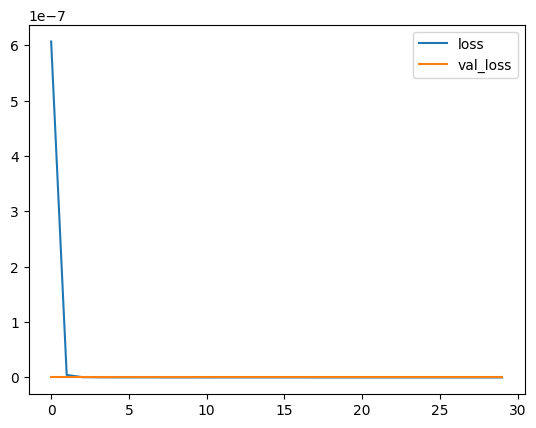

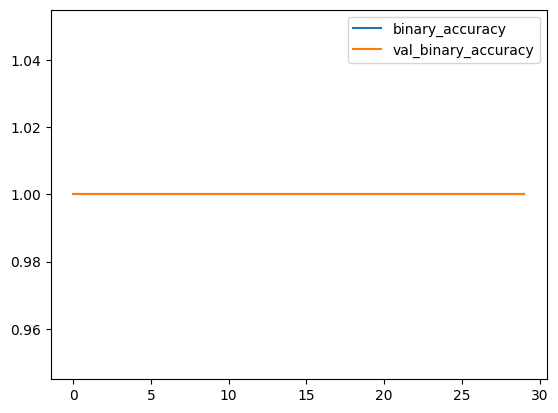

In [99]:
history_df = pd.DataFrame(history.history)#this creates a new df that keeps track of the training/validation 
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Minimum training loss: {}".format(history_df['loss'].min()))

In [100]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
# model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss='BinaryCrossentropy',
#               metrics=['binary_accuracy'])

model.compile(optimizer='adam',
              loss=BinaryCrossentropy(from_logits=False),  # Ensure this is an instance
              metrics=['binary_accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history = model.fit(
    train_X, train_y,  #ADD the CORRECT df's for testing data
    validation_data=(valid_X,valid_y),   #ADD the CORRECT df's for validation data
    batch_size=64,
    epochs=500,
    callbacks=[early_stopping], # put callbacks in a list
    verbose=0,  # turn off training log
)

Minimum validation loss: 4.485199333180315e-16
Minimum training loss: 7.554397385423073e-11


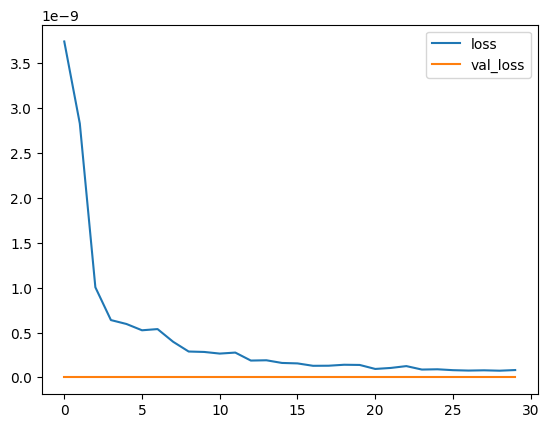

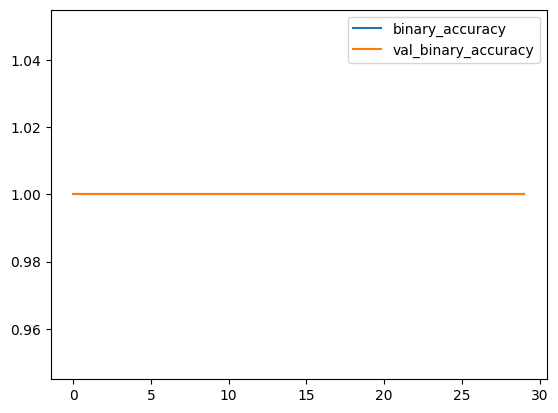

In [101]:
history_df = pd.DataFrame(history.history)#this creates a new df that keeps track of the training/validation 
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Minimum training loss: {}".format(history_df['loss'].min()))